# Esonero 2 - 17 Maggio 2021

Completare i seguenti esercizi tramite uno o più blocchi di codice descrivendo le operazioni effettuate


# Esercizio 1

Data la seguente immagine, costruire la feature pyramid di gaussiane e descrivere il procedimento

![](figure1.jpg)

Applico all'immagine di partenza un filtro gaussiano, con valori di sigma (deviazione standard) differenti, in particolare crescenti. Questa cosa  simula la perdita di dettagli che occorrerebbe se la scala dell'immagine decrescesse progressivamente.  Proviamo a plottare le varie figure dimezzando le dimensioni ad ogni passaggio

In [4]:
import numpy.linalg as LA
from utils import *

img_src = ''

Shape (1200, 1920)


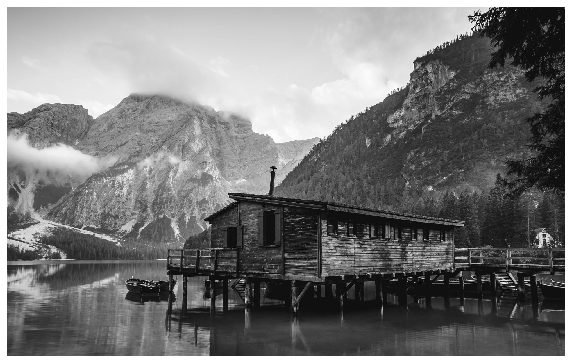

In [5]:
imageFull = mp_image.imread(os.path.join(img_src,'figure1.jpg'))

image = rgb2gray(imageFull) #converto l'immagine in scala di grigi

maxv, minv = np.max(image), np.min(image) # maxv è il valore del max pixel, minv è il valore del minimo pixel

image = (image - minv)/(maxv-minv) # è una sorta di normalizzazione (cioè di divisione per il valore del pixel massimo)

print('Shape', image.shape)
img_show(image,cmap=cm.gray)

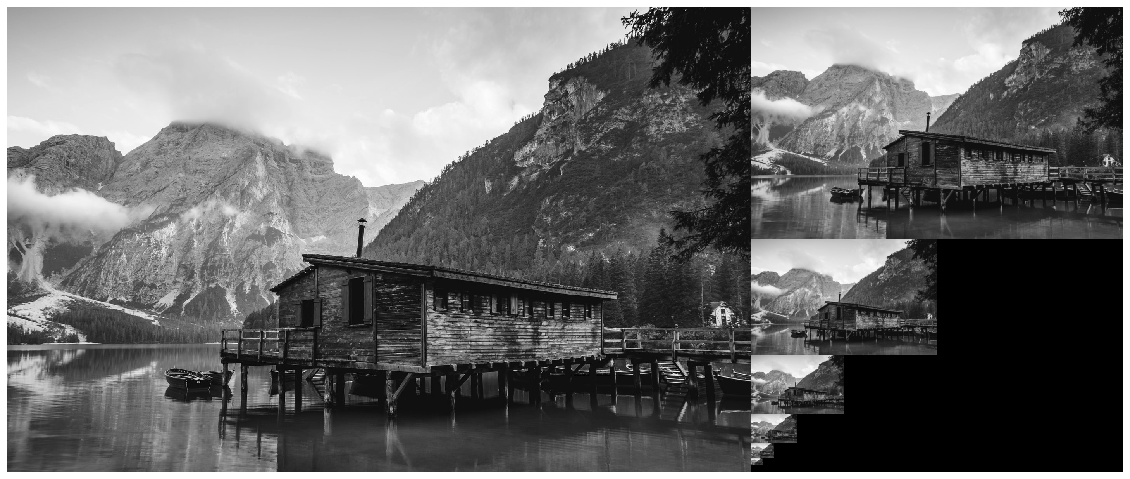

In [11]:
rows,cols = image.shape

output = np.zeros((rows,cols+cols//2)) #inizializzo un sottofondo nero su cui andrò a plottare l'immagine nelle varie scale

output[:rows,:cols] = image

num_octave = 6

cur_scale = image

horiz = True
rows = 0

#questo for mi serve per generare l'immagine nelle varie applicazioni della gaussiana, riducendo anche la dimensione 
#dell'immagine nella scala a 1/4 della dimensione dell'immagine ad essa precedente
for i in range(num_octave):
    sigma = 2**i # il valore di sigma. Nel primo caso vale 1, poi 2, poi 4.. insomma 2^i. Fino a un valore massimo di num_octave-1.
                        #questo altro non è che il valore della deviazione standard della gaussiana che sto per applicare.
    cur_scale = ndimage.gaussian_filter(image,sigma) #applico il filtro gaussiano con sigma pari a 2^i
    cur_scale = cur_scale[::2**(i+1),::2**(i+1)]
    rows_scaled, cols_scaled = cur_scale.shape
    output[rows:rows+rows_scaled,cols:cols+cols_scaled] = cur_scale #plotto l'immagine a dimensione ridotta nel corrispondente spazio nell'immagine di output
    rows += rows_scaled
        
        
plt.figure(figsize=(20, 20))

plt.imshow(output,cmap=cm.gray)
plt.axis('off')
plt.show()

Nel sottoriquadro grande di sinistra abbiamo l'immagine di partenza, mentre a destra abbiamo le riduzioni.

Disegnamo ora la scala nella rappresentazione diciamo "estesa":

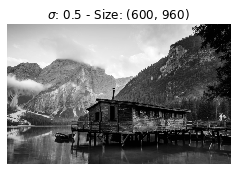

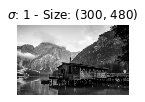

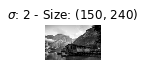

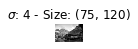

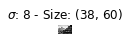

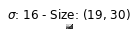

In [7]:
sz = 4

num_octave = 6

cur_scale = np.copy(image)
sigma = 1

for i in range(num_octave):
    cur_scale = ndimage.gaussian_filter(cur_scale,sigma)
    cur_scale = cur_scale[::2,::2]
    
    plt.figure(figsize=(sz, sz))
    plt.imshow(cur_scale,cmap=cm.gray)
    s = 2*np.ceil(3*2**(i-1))+1
    plt.title(f'$\sigma$: {2**(i-1)} - Size: {cur_scale.shape}')
    plt.axis('off')
    plt.show()
    
    sz = sz/2
    


# Esercizio 2


Data la seguente sequenza di tensori e la funzione *f*, calcolare il gradiente per i tensori a,b,c,d,e,y. 

Descrivere come viene costruito il grafo di computazione mostrando quali operazioni vengono effettuate, cioè calcolando le derivate parziali in maniera esplicita. 

$
y = f(a,b,c,d,e) = \sum \frac {a^3 + \exp(b^2) * \cos (c*d)} {3e}
$

*non sono necessarie librerie esterne*

In [62]:
a = torch.tensor([5, 6, 7, 8, 1, 2], dtype=torch.float, requires_grad=True).view(3, 2)
b = torch.tensor([3, 3, 0, 1, 6, 2], dtype=torch.float, requires_grad=True).view(3, 2)
c = torch.tensor([1, 5, 0, 7, 4, 3], dtype=torch.float, requires_grad=True).view(3, 2)
d = torch.tensor([2, 6, 3, 8, 3, 1], dtype=torch.float, requires_grad=True).view(3, 2)
e = torch.tensor([5, 2, 1, 1, 1, 1], dtype=torch.float, requires_grad=True).view(3, 2)

#i tensori a,b,c,d,e sono stati istanziati con 
#requires_grad=true, cioè 
#il tensore in questione deve essere una variabile o una costante?
#se passo true significa che posso calcolare la derivata di questa funzione rispetto ad x
                              
m1= torch.pow(a,3)
m1.retain_grad() #con questa funzione calcolo la derivata parziale
m2= torch.pow(b,2)
m2.retain_grad()
m22= torch.exp(m2)
m22.retain_grad()
cd= c*d
cd.retain_grad()
m3 = torch.cos(cd)
m3.retain_grad()

m3fin=m22*m3
m3fin.retain_grad()

numer = m1 + m3fin
numer.retain_grad()

denom= 3*e
denom.retain_grad()

numdem = numer/denom
numdem.retain_grad()

y=torch.sum(numdem)
print(y)

y.backward()



tensor(1.2127e+15, grad_fn=<SumBackward0>)


# Esercizio 3

Dati due batch A e B, mostrare gli effetti della BN.

Suggerimento: calcolare gli istogrammi di A e B



La batch normalization applica una normalizzazione però a livello globale, ovvero sull'intero batch. Cioè se 2 batch successivi hanno caratteristiche totalmente diverse (cioè in uno ho la predominanza del canale blu e in uno del canale rosso ) le 2 operazioni successive di back propagation cambiano in maniera significativa i pesi del modello.
Questo tipo di comportamento si chiama co-variance shift cioè costringo la rete a rincorrere in modo conflittuale 2 ottimi diversi perchè appunto ho ricevuto batch a variabilità elevataIl layer di batch normalization cambia il valore del tensore in input senza cambiare le caratteristiche principali dei dati

In [ ]:
a = torch.ones(1, 3, 10, 10)
b = torch.ones(1, 3, 10, 10) 

for f in range(b.shape[1]):
    for i in range(b.shape[2]):
        for j in range(b.shape[3]):
            b[0, f, i, j] = b[0, f, i, j] * 200
            
#questi 2 batch li do al layer di batch normalization

# Esercizio 4

Dato il seguente frammento di codice

In [24]:
import torch
conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, padding=1, stride=2)
conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))

model = lambda x: conv2(conv1(x))

Indicare giustificando la risposta qual'è il risultato per un'immagine 1x3x400x400 illustrandolo con un esempio. 

Questo codice applica semplicemente 2 convoluzioni in cascata. In particolare la prima riceve in input un immagine a 3 canali (in quanto in_channel = 3, e la cosa è giusta perchè sto applicando la convoluzione ad un immagine RGB), che restituisce in output una feature map a 10 canali. Il kernel che applico è un kernel 3x3. Il padding è 1 e lo stride è 2 (il che significa che le convoluzioni che applico da destra a sinistra e dall'alto al basso non vanno a passo di 1 ma a passo di 2). 
Chiaramente anche la seconda convoluzione opera in modo analogo. L'unica cosa particolare è che i valori di kernel_size, padding e stride sono tuple, il che significa che il primo è usato per la height e il secondo per la width.


In [55]:
x = torch.rand(1,3,400,400)

In [56]:
x.shape

torch.Size([1, 3, 400, 400])

In [59]:
output=model(x)

In [60]:
output.shape

torch.Size([1, 30, 66, 50])

In [72]:
conv_dim_compute = lambda i, k, d, s, p: ((i - k - ( k - 1) * ( d - 1) + 2 * p) / s) + 1
print(conv_dim_compute(400,3,1,2,1))


200.5


# Esercizio 5

Adattare/semplificare la rete VGG affinché gestisca un input di immagini 400x400

In [ ]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 12 * 12, 4096), #sistemo solo questa cosa qui, perchè invece che ricevere immagini 224x224, riceve immagini 400x400
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


                



# Esercizio 6

Data la seguente immagine, calcolare la IoU tra i due box mostrati in figura. 
Descrivere tutte le operazioni effettuate

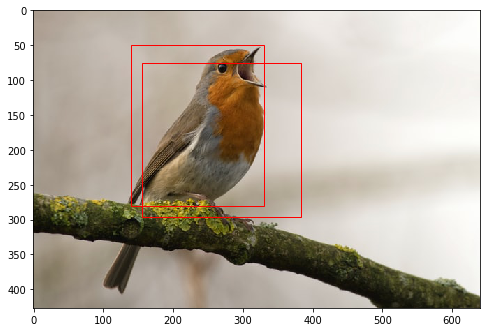

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import matplotlib.patches as patches

def plot_bbox(image_np, bbox_list):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8, 8)

    ax.imshow(image_np)

    for bbox_idx in range(bbox_list.shape[0]):
        x1, y1, x2, y2 = bbox_list[bbox_idx, :].tolist()

        w = x2 - x1
        h = y2 - y1

        rect = patches.Rectangle((x1, y1), w, h,
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')

        ax.add_patch(rect)

    plt.show();

imageBB1 = mp_image.imread('figure2.jpg')

bb1 = [140, 50, 330, 280]
bb2 = [156, 75, 384, 297]

plot_bbox(imageBB1, np.array([bb1, bb2]))

L'IoU è una metrica usata per calcolare la sovrapposizione tra 2 box. Cioè,dati 2 box A e B è pari a:
IoU= (A intersecato B)/(A unito B)
Quindi sarà pari a 1 se i 3 box sono perfettamente sovrapposti, mentre è pari a 0 se i 2 box non hanno nessun frammento in comune.
L'IoU serve per calcolare l'accuratezza di un object detector

La strategia per calcolare il valore IoU tra 2 box è la seguente:

- Individuare il max sulle coord x e y
- Individuare il min sulle coord x e y
- Mo, se c'è un intersezione, che mi calcolo così:
 if (xn1 < xn2) and (yn2 < yn1)
     #allora in tal caso l'area la calcolo come prodotto
     - iou_area will be (xn2 - xn1) * (yn2 - yn1)

 else#se nonc'è intersezione, il valore sarà 0:
      - iuo_area will be 0- similarly calculate area for anchor box and ground truth object
  #l'IoU sarà:
- iou = iou_area/(anchor_box_area + ground_truth_area - iou_area)

In [71]:
anchor_area =(bb1[2]-bb1[0])*(bb1[3]-bb1[1])

inter_x1 = max(bb1[1], bb2[1])
inter_y1 = max(bb1[0], bb2[0])
inter_x2 = min(bb1[3], bb2[3])
inter_y2 = min(bb1[2], bb2[2])

box_area =(bb2[2]-bb2[0])*(bb2[3]-bb2[1])

if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
    iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
    iou = iter_area / (anchor_area + box_area - iter_area)
else:
    iou = 0.

print(iou)

0.608225624936057
